<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Part I - 2 <br><br><br>
  Sentence Classification
  </div> 

  <div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. <font color=red>**Sentence Classification**</font>

3. Language Modeling

4. Sequence Labelling


### Part II

5. Auto-Encoding

6. Machine Translation

7. Text Classification




### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | | |
|------|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | [Open source models](#open_source_models) | 

# Overview


The global structure of the [sentence classifier](#classifier) is the pipeline of three modules, followed by a final classification layer :



| | Module |  | |
|------|------|------|------|
| 1 | **Word Embedding** | [I.1 Custom model](#word_level_custom) | [I.2 Gensim Model](#gensim) | [I.3 FastText model](#fastText) |
| 2 | **Contextualization** | [II.1 bidirectionnal GRU](#bi_gru) | [II.2 Transformer](#transformer) |
| 3 | **Self-Attention** | [III.1 Self-Attention](#attention) | [III.2 Multi-head Self-Attention](#multihead_attention) |



All details on Word Embedding modules and their pre-training are found in **Part I - 1**.

# Packages

In [1]:
import sys
import warnings
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.3.1
DL device : cuda


In [2]:
path_to_NLP = 'C:\\Users\\Jb\\Desktop\\NLP'

In [3]:
sys.path.append(path_to_NLP + '\\libDL4NLP')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.<br> Le corpus est donc une fois importé sous le forme :<br>

- corpus = [[text, label]]<br>
- text   = str<br>
- label = int

In [4]:
def cleanSentence(sentence): # -------------------------  str
    sw = ['']
    #sw += nltk.corpus.stopwords.words('english')
    #sw += nltk.corpus.stopwords.words('french')

    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join( c for c in unicodedata.normalize('NFD', s)
                        if unicodedata.category(c) != 'Mn')

    def normalizeString(s):
        '''Remove rare symbols from a string'''
        s = unicodeToAscii(s.lower().strip()) # 
        #s = re.sub(r"[^a-zA-Z\.\(\)\[\]]+", r" ", s)  # 'r' before a string is for 'raw' # ?&\%\_\- removed # set('''.,:;()*#&-_%!?/\'")''')
        return s

    def wordTokenizerFunction():
        # base version
        function = lambda sentence : sentence.strip().split()

        # nltk version
        #function = word_tokenize    
        return function

    # 1 - caractères spéciaux
    def clean_sentence_punct(text): # --------------  str
        text = normalizeString(text)
        # suppression de la dernière ponctuation
        if (len(text) > 0 and text[-1] in ['.', ',', ';', ':', '!', '?']) : text = text[:-1]

        text = text.replace(r'(', r' ( ')
        text = text.replace(r')', r' ) ')
        text = text.replace(r'[', r' [ ')
        text = text.replace(r']', r' ] ')
        text = text.replace(r'<', r' < ')
        text = text.replace(r'>', r' > ')

        text = text.replace(r':', r' : ')
        text = text.replace(r';', r' ; ')
        for i in range(5) :
            text = re.sub('(?P<val1>[0-9])\.(?P<val2>[0-9])', '\g<val1>__-__\g<val2>', text)
            text = re.sub('(?P<val1>[0-9]),(?P<val2>[0-9])', '\g<val1>__-__\g<val2>', text)
        text = text.replace(r',', ' , ')
        text = text.replace(r'.', ' . ')
        for i in range(5) : text = re.sub('(?P<val1>[p0-9])__-__(?P<val2>[p0-9])', '\g<val1>.\g<val2>', text)
        text = re.sub('(?P<val1>[0-9]) \. p \. (?P<val2>[0-9])', '\g<val1>.p.\g<val2>', text)
        text = re.sub('(?P<val1>[0-9]) \. s \. (?P<val2>[0-9])', '\g<val1>.s.\g<val2>', text)

        text = text.replace(r'"', r' " ')
        text = text.replace(r'’', r" ' ")
        text = text.replace(r'”', r' " ')
        text = text.replace(r'“', r' " ')
        text = text.replace(r'/', r' / ')

        text = re.sub('(…)+', ' … ', text)
        text = text.replace('≤', ' ≤ ')          
        text = text.replace('≥', ' ≥ ')
        text = text.replace('°c', ' °c ')
        text = text.replace('°C', ' °c ')
        text = text.replace('ºc', ' °c ')
        text = text.replace('n°', 'n° ')
        text = text.replace('%', ' % ')
        text = text.replace('*', ' * ')
        text = text.replace('+', ' + ')
        text = text.replace('-', ' - ')
        text = text.replace('_', ' ')
        text = text.replace('®', ' ')
        text = text.replace('™', ' ')
        text = text.replace('±', ' ± ')
        text = text.replace('÷', ' ÷ ')
        text = text.replace('–', ' - ')
        text = text.replace('μg', ' µg')
        text = text.replace('µg', ' µg')
        text = text.replace('µl', ' µl')
        text = text.replace('μl', ' µl')
        text = text.replace('µm', ' µm')
        text = text.replace('μm', ' µm')
        text = text.replace('ppm', ' ppm')
        text = re.sub('(?P<val1>[0-9])mm', '\g<val1> mm', text)
        text = re.sub('(?P<val1>[0-9])g', '\g<val1> g', text)
        text = text.replace('nm', ' nm')

        text = re.sub('fa(?P<val1>[0-9])', 'fa \g<val1>', text)
        text = re.sub('g(?P<val1>[0-9])', 'g \g<val1>', text)
        text = re.sub('n(?P<val1>[0-9])', 'n \g<val1>', text)
        text = re.sub('p(?P<val1>[0-9])', 'p \g<val1>', text)
        text = re.sub('q_(?P<val1>[0-9])', 'q_ \g<val1>', text)
        text = re.sub('u(?P<val1>[0-9])', 'u \g<val1>', text)
        text = re.sub('ud(?P<val1>[0-9])', 'ud \g<val1>', text)
        text = re.sub('ui(?P<val1>[0-9])', 'ui \g<val1>', text)

        text = text.replace('=', ' ')
        text = text.replace('!', ' ')
        text = text.replace('-', ' ')
        text = text.replace(r' , ', ' ')
        text = text.replace(r' . ', ' ')

        text = re.sub('(?P<val>[0-9])ml', '\g<val> ml', text)
        text = re.sub('(?P<val>[0-9])mg', '\g<val> mg', text)

        for i in range(5) : text = re.sub('( [0-9]+ )', ' ', text)
        #text = re.sub('cochran(\S)*', 'cochran ', text)
        return text

    # 3 - split des mots
    def wordSplit(sentence, tokenizeur): # ------------- [str]
        return tokenizeur(sentence)

    # 4 - mise en minuscule et enlèvement des stopwords
    def stopwordsRemoval(sentence, sw): # ------------- [[str]]
        return [word for word in sentence if word not in sw]

    # 6 - correction des mots
    def correction(text):
        def correct(word):
            return spelling.suggest(word)[0]
        list_of_list_of_words = [[correct(word) for word in sentence] for sentence in text]
        return list_of_list_of_words

    # 7 - stemming
    def stemming(text): # ------------------------- [[str]]
        list_of_list_of_words = [[PorterStemmer().stem(word) for word in sentence if word not in sw] for sentence in text]
        return list_of_list_of_words

    tokenizeur = wordTokenizerFunction()
    sentence = clean_sentence_punct(str(sentence))
    sentence = wordSplit(sentence, tokenizeur)
    sentence = stopwordsRemoval(sentence, sw)
    #text = correction(text)
    #text = stemming(text)
    return sentence


def importSheet(file_name) :
    df = pd.read_excel(file_name, sep = ',', header = None)
    headers = [i for i, titre in enumerate(df.ix[0,:].values) if i in [1, 2] or titre == 'score manuel'] 
    db = df.ix[1:, headers].values.tolist()
    labelled_sentences = [[' '.join(cleanSentence(str(el[0]) + ' | ' + str(el[1]))), el[-1]] for el in db if el[-1] in [0, 1]]
    return labelled_sentences


def importCorpus(path_to_data) :
    corpus = []
    reps = os.listdir(path_to_data)
    for rep in reps :
        files = os.listdir(path_to_data + '\\' + rep)
        for file in files :
            file_name = path_to_data + '\\' + rep + '\\' + file
            corpus += importSheet(file_name)
    return corpus

In [5]:
labelled_sentences = importCorpus(path_to_NLP + '\\data\\AMM')

In [6]:
labelled_sentences[0]

['section 3.2.p.5.1 specification ( s ) | the testing performed on the finished product ( fp ) is in compliance with both current european pharmacopoeia ( ph eur ) and world health organization ( who ) requirements of the vaccine',
 1]

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

We assume that embedding model were pretrained following the steps detailed in **Part I - 1**.<br>
We consider here Word2Vec models pre-trained following the Skip-Gram training objective.

Since the chosen word embedding model must interact with subsequent modules int the sentence classification model, we wrap each model into a common small module that uniformize communication between any of these modules with subsequent ones.

To speed up training we want to pre-pack sentences into mini-batches, each mini-batch forming a single Torch Variable. There are two issues for this :<br> First, packing sentences into mini-batches needs to introduce a additionnal _padding_ word in the Word2Vc model, in order to put sentences of a single mini-batch at equal length. Second, the Word2Vc model must be able to handle Torch Variables, which is not the case for Gensim and FastText models.

A solution to these issues is to associate to the Word2Vec model a _twin_, which will be a Pytorch module containing and additionnal padding word/vector.


The strength of FastText is the possiblity to advocate a word vctor to most unseen word by taking embedding of subword units.<br> However this advantage no longer exists for the Pytorch twin, since in such model only the lookup table remains.<br> Therefore it is necessary to wrap the fastText model into another Pytorch model, which will use a twin of the model for fast training and then use the original Word2Vec model for inference.

All models are frozen after being loaded, so that none of their parameters is targeted by the sentence classifier optimizer.

In [7]:
class Word2VecConnector(nn.Module) :
    '''A Pytorch module wrapping a FastText word2vec model'''
    def __init__(self, word2vec) :
        super(Word2VecConnector, self).__init__()
        self.word2vec = word2vec
        self.twin = myWord2Vec(lang = Lang([list(word2vec.wv.index2word)], base_tokens = []), T = word2vec.wv.vectors)
        self.twin.addWord('PADDING_WORD')
        self.twin.addWord('UNK')
        self.twin = self.twin.freeze()
        
        self.lang       = self.twin.lang
        self.embedding  = self.twin.embedding
        self.output_dim = self.twin.output_dim
        
    def lookupTable(self) :
        return self.word2vec.wv.vectors
        
    def forward(self, words, device = None) :
        '''Transforms a sequence of n words into a Torch FloatTensor of size (1, n, emb_dim)'''
        try :
            embeddings = Variable(torch.Tensor(self.word2vec[words])).unsqueeze(0)
            if device is not None : embeddings = embeddings.to(device)
        except :
            embeddings = self.twin(words, device)
        return embeddings

<a id="word_level_custom"></a>


#### 1.1.1 Custom model

In [8]:
from libDL4NLP.models import Word2Vec as myWord2Vec
from libDL4NLP.utils import Lang

In [9]:
custom_word2vec = torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_I1_skipgram.pt').freeze()

<a id="gensim"></a>

#### 1.1.2 Gensim model

In [10]:
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile

In [11]:
gensim_word2vec = Word2VecConnector(Word2Vec.load(get_tmpfile(path_to_NLP + "\\saves\\models\\DL4NLP_I1_skipgram_gensim.model")))

<a id="fastText"></a>

#### 1.1.3 FastText model

In [12]:
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

In [13]:
fastText_word2vec = Word2VecConnector(FastText.load(get_tmpfile(path_to_NLP + "\\saves\\models\\DL4NLP_I1_fasttext.model")))

### 1.2 Contextualization module

[Back to top](#plan)

The contextualization layer transforms a sequences of word vectors into another one, of same length, where each output vector corresponds to a new version of each input vector that is contextualized with respect to neighboring vectors.

<a id="bi_gru"></a>

#### 1.2.1 Bi-directionnal GRU contextualization

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [14]:
#from libDL4NLP.modules import RecurrentEncoder

In [15]:
class RecurrentEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_layers = 1, dropout = 0, bidirectional = False): 
        super(RecurrentEncoder, self).__init__()
        
        # relevant quantities
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = hidden_dim * (2 if bidirectional else 1)

        # layers
        self.dropout = nn.Dropout(p = dropout)
        self.bigru = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            n_layers,
                            dropout = (0 if n_layers == 1 else dropout), 
                            bidirectional = bidirectional,
                            batch_first = True)

    def forward(self, embeddings, lengths = None, hidden = None) :
        '''Transforms a batch of size (batch_size, input_length, embedding_dim) into 
        
              - outputs of size (batch_size, input_length, 2 * embedding_dim)
              - hidden  of size (batch_size, 2 * n_layers, embedding_dim)
        '''
        embeddings = self.dropout(embeddings)
        if lengths is not None : embeddings = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first = True)
        outputs, hidden = self.bigru(embeddings, hidden) # dim = (batch_size, input_length, output_dim)
        if lengths is not None : outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first = True)
        outputs = self.dropout(outputs)                  # dim = (batch_size, input_length, output_dim)
        hidden  = self.dropout(hidden)                   # dim = (batch_size, 2, hidden_dim)
        return outputs, hidden

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

#### 1.3.1 Classical Self-Attention Module


In [16]:
#from libDL4NLP.modules import SelfAttention

In [17]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim, dropout = 0): 
        super(SelfAttention, self).__init__()

        # relevant quantities
        self.embedding_dim = embedding_dim
        self.output_dim = embedding_dim

        # parameters
        self.dropout = nn.Dropout(p = dropout)
        self.attn_layer = nn.Linear(embedding_dim, embedding_dim)
        self.attn_v = nn.Linear(embedding_dim, 1, bias = False)
        self.act = F.softmax
        
    def forward(self, embeddings):
        weights = self.attn_layer(embeddings).tanh()       # size (minibatch_size, input_length, embedding_dim)
        weights = self.act(self.attn_v(weights), dim = 1)  # size (minibatch_size, input_length, 1)
        weights = torch.transpose(weights, 1, 2)           # size (minibatch_size, 1, input_length)
        applied = torch.bmm(weights, embeddings)           # size (minibatch_size, 1, embedding_dim)
        applied = self.dropout(applied)
        return applied, weights

<a id="multihead_attention"></a>

#### 1.3.2 Multi-head Self-Attention Module

- Idea presented at ICLR 2017 : [A structured self-attentive sentence embedding (2017)](https://arxiv.org/pdf/1703.03130.pdf)
- Latest development : [Orthogonality Constrained Multi-Head Attention For Keyword Spotting (2019)](https://arxiv.org/pdf/1910.04500.pdf)

In [18]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim, n_head = 1, dropout = 0): 
        super(MultiHeadSelfAttention, self).__init__()
        
        # relevant quantities
        self.embedding_dim = embedding_dim
        self.output_dim = n_head * embedding_dim
        self.n_head = n_head
        
        # parameters
        self.attn_list = nn.ModuleList([SelfAttention(embedding_dim, dropout) for i in range(n_head)])
        
    def compute_penalty(self, weights) :
        weights_t = torch.transpose(weights, 1, 2)
        def_pos = [torch.mm(weights[i], weights_t[i]) for i in range(weights.size(0))] # size (minibatch_size, n_heads, n_heads)
        ide = Variable(torch.eye(self.n_head)).to(device)
        penal = torch.sum(torch.cat([torch.norm(mmt - ide).view(1) for mmt in def_pos]))
        return penal
    
    def forward(self, embeddings, penal = False):
        outputs = [attn(embeddings) for attn in self.attn_list]
        applied = torch.cat([out[0] for out in outputs], dim = 2) # size (minibatch_size, 1, n_heads * embedding_dim)
        weights = torch.cat([out[1] for out in outputs], dim = 1) # size (minibatch_size, n_heads, input_length)
        if penal and self.n_head > 1 :
            penal = self.compute_penalty(weights)
            return applied, weights, penal
        elif penal : 
            return applied, weights, None
        else :
            return applied, weights

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [19]:
#from libDL4NLP.utils import heatmap, annotate_heatmap

In [20]:
def heatmap(data, row_labels, col_labels, ax = None, cbar_kw = {}, cbarlabel = "", **kwargs):
    if not ax: ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")
    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im

def annotate_heatmap(im, data = None, valfmt = "{x:.2f}", textcolors = ["black", "white"], threshold = None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.
    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)
    return texts

<a id="model"></a>

# 2 Sentence Classifier

[Back to top](#plan)


### Model

In [21]:
#from libDL4NLP.models import SentenceClassifier

In [22]:
class SentenceClassifier(nn.Module) :
    def __init__(self, device, tokenizer, word2vec, 
                 hidden_dim = 100, 
                 n_layers = 1, 
                 n_attn_heads = 1, 
                 n_class = 2, 
                 dropout = 0, 
                 class_weights = None, 
                 optimizer = optim.SGD
                 ):
        super(SentenceClassifier, self).__init__()
        
        # embedding
        self.bin_mode  = (n_class == 'binary')
        self.tokenizer = tokenizer
        self.word2vec  = word2vec
        self.context   = RecurrentEncoder(self.word2vec.output_dim, hidden_dim, n_layers, dropout, bidirectional = True)
        self.attention = MultiHeadSelfAttention(self.context.output_dim, n_head = n_attn_heads, dropout = dropout)
        self.out       = nn.Linear(self.attention.output_dim, (1 if self.bin_mode else n_class))
        self.act       = F.sigmoid if self.bin_mode else F.softmax
        
        # optimizer
        if self.bin_mode : self.criterion = nn.BCEWithLogitsLoss(size_average = False)
        else             : self.criterion = nn.NLLLoss(size_average = False, weight = class_weights)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    def showAttention(self, words, attn) :
        for i in range(attn.size(1)) :
            fig, ax  = plt.subplots()
            im       = heatmap(np.array(attn[:, i, :].data.cpu().numpy()),  [' '], words, ax=ax, cmap="YlGn", cbarlabel="harvest [t/year]")
            texts    = annotate_heatmap(im, valfmt="{x:.2f}")
            fig.tight_layout()
            plt.show()
        return
        
    def forward(self, sentence, show_attention = False) :
        '''classifies a sentence as string'''
        words         = self.tokenizer(sentence)
        embeddings    = self.word2vec(words, self.device)
        hiddens, _    = self.context(embeddings) 
        attended, atn = self.attention(hiddens)
        if self.bin_mode : prediction = self.act(self.out(attended).view(-1)).data.topk(1)[0].item()
        else             : prediction = self.act(self.out(attended.squeeze(1)), dim = 1).data.topk(1)[1].item()
        if show_attention : self.showAttention(words, atn)
        return prediction
    
    def generatePackedSentences(self, sentences, batch_size = 32) :
        sentences.sort(key = lambda s: len(self.tokenizer(s[0])), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            pack0 = [self.tokenizer(s[0]) for s in sentences[i:i + batch_size]]
            pack0 = [[self.word2vec.lang.getIndex(w) for w in words] for words in pack0]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack0.sort(key = len, reverse = True)
            lengths = torch.tensor([len(p) for p in pack0])               # size = (batch_size) 
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.word2vec.lang.getIndex('PADDING_WORD')))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1))     # size = (batch_size, max_length)
            pack1 = [[el[1]] for el in sentences[i:i + batch_size]]
            if self.bin_mode : pack1 = Variable(torch.FloatTensor(pack1)) # size = (batch_size) 
            else             : pack1 = Variable(torch.LongTensor(pack1))  # size = (batch_size) 
            packed_data.append([[pack0, lengths], pack1])
        return packed_data
    
    def compute_accuracy(self, sentences) :
        batches = self.generatePackedSentences(sentences, batch_size = 32)
        score = 0
        for batch, target in batches :
            embeddings  = self.word2vec.embedding(batch[0].to(self.device))
            hiddens, _  = self.context(embeddings, lengths = batch[1].to(self.device))
            attended, _ = self.attention(hiddens)
            if self.bin_mode : 
                vects  = self.out(attended).view(-1)
                target = target.to(self.device).view(-1)
                score += sum(torch.abs(target - self.act(vects)) < 0.5).item()
            else : 
                log_probs = F.log_softmax(self.out(attended.squeeze(1)))
                target    = target.to(self.device).view(-1)
                score    += sum([target[i].item() == log_probs[i].data.topk(1)[1].item() for i in range(target.size(0))])
        return score * 100 / len(sentences)
    
    def fit(self, batches, iters = None, epochs = None, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeLogProbs(batch) :
            embeddings  = self.word2vec.embedding(batch[0].to(self.device))
            hiddens, _  = self.context(embeddings, lengths = batch[1].to(self.device))
            attended, _, penal = self.attention(hiddens, penal = True)
            if self.bin_mode : return self.out(attended).view(-1), penal
            else             : return F.log_softmax(self.out(attended.squeeze(1))), penal

        def computeAccuracy(log_probs, targets) :
            if self.bin_mode : return sum(torch.abs(targets - self.act(log_probs)) < 0.5).item() * 100 / targets.size(0)
            else             : return sum([targets[i].item() == log_probs[i].data.topk(1)[1].item() for i in range(targets.size(0))]) * 100 / targets.size(0)
            
        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update."""
            optimizer.zero_grad()
            self.zero_grad()
            log_probs, penal = computeLogProbs(batch[0])
            targets = batch[1].to(self.device).view(-1)
            loss    = self.criterion(log_probs, targets)
            if penal is not None and penal.item() > 10 : loss = loss + penal
            loss.backward()
            optimizer.step() 
            accuracy = computeAccuracy(log_probs, targets) if compute_accuracy else 0
            return float(loss.item() / targets.size(0)), accuracy
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

### Training

In [23]:
classifier = SentenceClassifier(device,
                                tokenizer = lambda s : s.split(' '),
                                word2vec = custom_word2vec,
                                hidden_dim = 50, 
                                n_layers = 2,
                                n_attn_heads = 1,
                                n_class = 'binary', 
                                dropout = 0.15)

classifier.nbParametres()

94001

In [24]:
classifier

SentenceClassifier(
  (word2vec): Word2Vec(
    (embedding): Embedding(4066, 75)
  )
  (context): RecurrentEncoder(
    (dropout): Dropout(p=0.15, inplace=False)
    (bigru): GRU(75, 50, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True)
  )
  (attention): MultiHeadSelfAttention(
    (attn_list): ModuleList(
      (0): SelfAttention(
        (dropout): Dropout(p=0.15, inplace=False)
        (attn_layer): Linear(in_features=100, out_features=100, bias=True)
        (attn_v): Linear(in_features=100, out_features=1, bias=False)
      )
    )
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
  (criterion): BCEWithLogitsLoss()
)

In [25]:
batches = classifier.generatePackedSentences(labelled_sentences, batch_size = 64)

In [26]:
classifier.fit(batches, epochs = 10, lr = 0.01, print_every = 100)

epoch 1
0m 5s (- 2m 45s) (100 3%) loss : 0.393  accuracy : 83.9 %
0m 9s (- 2m 32s) (200 6%) loss : 0.256  accuracy : 89.2 %
0m 14s (- 2m 24s) (300 9%) loss : 0.196  accuracy : 91.9 %
epoch 2
0m 19s (- 2m 19s) (400 12%) loss : 0.190  accuracy : 92.2 %
0m 24s (- 2m 13s) (500 15%) loss : 0.164  accuracy : 93.4 %
0m 28s (- 2m 7s) (600 18%) loss : 0.172  accuracy : 92.5 %
epoch 3
0m 33s (- 2m 2s) (700 21%) loss : 0.171  accuracy : 92.8 %
0m 38s (- 1m 56s) (800 24%) loss : 0.145  accuracy : 94.0 %
0m 42s (- 1m 51s) (900 27%) loss : 0.152  accuracy : 93.5 %
epoch 4
0m 47s (- 1m 47s) (1000 30%) loss : 0.143  accuracy : 94.1 %
0m 52s (- 1m 42s) (1100 33%) loss : 0.141  accuracy : 94.2 %
0m 57s (- 1m 37s) (1200 36%) loss : 0.128  accuracy : 94.8 %
1m 2s (- 1m 33s) (1300 40%) loss : 0.133  accuracy : 94.6 %
epoch 5
1m 6s (- 1m 28s) (1400 43%) loss : 0.120  accuracy : 95.0 %
1m 11s (- 1m 23s) (1500 46%) loss : 0.126  accuracy : 95.0 %
1m 16s (- 1m 19s) (1600 49%) loss : 0.125  accuracy : 94.9 %
ep

In [27]:
# save
#torch.save(classifier.state_dict(), path_to_NLP + '\\saves\\models\\DL4NLP_I2_sentence_classifier.pth')

# load
#classifier.load_state_dict(torch.load(path_to_NLP + '\\saves\\models\\DL4NLP_I2_sentence_classifier.pth'))

#### Evaluation single-head

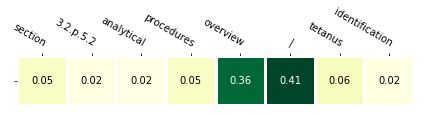

0.9791029095649719

In [28]:
# attention heads = 1
classifier.eval()
classifier('section 3.2.p.5.2 analytical procedures overview | tetanus identification', show_attention = True)

In [29]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences)

97.81081601231716

#### Evaluation multi-head

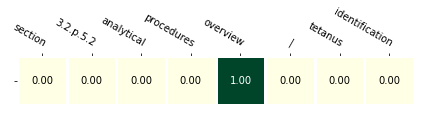

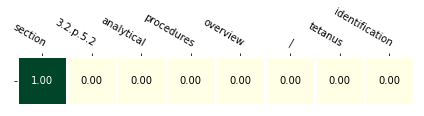

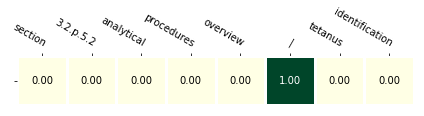

0.9900434017181396

In [27]:
# attention heads = 3
classifier.eval()
classifier('section 3.2.p.5.2 analytical procedures overview | tetanus identification', show_attention = True)

In [28]:
classifier.eval()
classifier.compute_accuracy(labelled_sentences)

97.2863741339492

#### Save

In [62]:
#torch.save(classifier.state_dict(), path_to_NLP + '\\saves\\DL4NLP_I2_sentence_classifier.pth')

<a id="open_source_models"></a>

# 3 Open source models

[Back to top](#plan)

### 3.1 HuggingFace Transformers

The repo is located at [this address](https://github.com/huggingface/transformers).

A simple tutorial for binary sentence classification is given [here](https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa).

### 3.2 SimpleTransformers (build on top of HuggingFace)

Explanations are found [here](https://towardsdatascience.com/simple-transformers-introducing-the-easiest-bert-roberta-xlnet-and-xlm-library-58bf8c59b2a3) and [here](https://medium.com/swlh/simple-transformers-multi-class-text-classification-with-bert-roberta-xlnet-xlm-and-8b585000ce3a).





In [30]:
# INSTALL apex
from simpletransformers.classification import ClassificationModel

In [31]:
df = pd.DataFrame(labelled_sentences, columns = ['text', 'label'])

In [35]:
print(df.shape)
df.head()

(20784, 2)


,text,label
0,section 3.2.p.5.6 justification of specificati...,1
1,section 3.2.p.5.3 validation of analytical pro...,0
2,section 3.2.p.5.3 validation of analytical pro...,0
3,section 3.2.p.5.6 justification of specificati...,0
4,section 3.2.p.5.6 justification of specificati...,0


In [38]:
df_trn, df_tst = df.iloc[:15000, :], df.iloc[15000:, :]

In [42]:
torch.cuda.empty_cache()

In [40]:
simpletransformers_model = ClassificationModel('bert', 'bert-base-cased', num_labels = 2, 
                                               args = {'num_train_epochs': 1, 'learning_rate': 3e-5})

In [44]:
simpletransformers_model.train_model(df_trn)

Features loaded from cache at cache_dir/cached_train_bert_128_2_15000


ImportError: Please install apex from https://www.github.com/nvidia/apex to use fp16 training.

In [ ]:
result, model_outputs, wrong_predictions = simpletransformers_model.eval_model(eval_df)